In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind as ttest

In [2]:
def calculate_time(path):
    # load data, format: frame #, label
    temp_df = pd.read_csv(path, index_col = 0)
    grooming = len(temp_df[temp_df["Labels"] == "Grooming"].values)
    non_grooming = len(temp_df[temp_df["Labels"] == "Not Grooming"].values)
    
    return grooming, non_grooming

def get_true_grooming(path):
    hand = pd.read_csv(path)
    start = hand["Start Time(s)"].values *30
    duration = hand["Duration(Second)"].values

    hand_label = []
    for i in range(len(start)):
        temp = duration[i]*30
        j = 0
        while temp > j:
            hand_label.append(int(start[i]+j))
            j += 1
    return hand_label

def filter_out_short(grooming):
    pervious = 0
    temp_seq = []
    filtered = []
    for i in grooming.index.values:
        gap = i - pervious
        #print(gap)
        if gap > 5:
            # gap too big 
            if len(temp_seq) >= 10:
                # keep it in the result:
                filtered += temp_seq
                # considering drop minor segments
                # ex. total length < 10 frames
            temp_seq = []
        else:
            #if gap <= 5:
            # combine two segments(add node)
            temp_seq.append(i)
            #print(temp_seq)
        pervious = i
    return filtered

def plot_grooming(hand_label, predict_path, tilte, filter_out = False, time = 1):
    temp_df = pd.read_csv(predict_path, index_col = 0)
    grooming = temp_df[temp_df["Labels"] == "Grooming"]
    fig = plt.figure(figsize = (10,2))
    
    if filter_out == True:
        grooming = filter_out_short(grooming)
        
        plt.scatter(grooming, np.full(len(grooming), 1)
                    ,marker = "|", s = 20000, alpha = 0.3)
        plt.xticks(np.arange(0,180000,1800*1), np.arange(0,100, 1))
        plt.scatter(hand_label, np.full(len(hand_label), 1.1)
                    ,marker = "|", s = 20000, alpha = 0.3)
        
    else:
    
        plt.scatter(grooming.index[:18000], np.full(len(grooming.index[:18000]), 1)
                    ,marker = "|", s = 20000, alpha = 0.3)
        plt.xticks(np.arange(0,180000,1800*1), np.arange(0,100, 1))
        plt.scatter(hand_label, np.full(len(hand_label), 1.1)
                    ,marker = "|", s = 20000, alpha = 0.3)
    plt.title(title, fontsize = 20)
    
    plt.xlim(-900+18000*(time-1),1800*10*time)
    plt.grid()
    return fig, grooming

def plot_cm(path, fn ='ConfustionMatrix_test.png'):
    cm_data_test = pd.read_csv(path, index_col = 0)

    f = plt.figure(figsize=(12,8))
    ax = f.add_subplot(111)
    ind = np.arange(len(cm_data_test))
    width = 0.2

    rects2 = ax.bar(ind, cm_data_test["TN"], 2*width, color='seagreen')
    rects3 = ax.bar(ind+width, cm_data_test["FP"], width, color='red')
    rects4 = ax.bar(ind+2*width, cm_data_test["FN"], width, color='purple')
    ax.set_ylabel('Counts')
    ax.set_title('Confusion Matrix for Grooming Prediction', fontsize = 20)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(cm_data_test.index)
    ax.legend( (rects2[0],rects3[0], rects4[0]), 
              ('correct prediction', "missed prediction",'wrong prediction') )
    plt.show()
    f.savefig(fn)
    
    return cm_data_test

def calcualte_performence(cm_data):
    TP = cm_data["TN"].values
    TN = cm_data["TP"].values
    FP = cm_data["FN"].values
    FN = cm_data["FP"].values

    Accuracy = (TP+TN)/(TP+TN+FP+FN)
    Precision = TP/(TP+FP)
    #print(Precision)
    Recall = TP/(TP+FN)
    #print(Recall)
    F1 = 2*(Precision*Recall)/(Precision + Recall)
    #print(F1)
    return Accuracy, Precision, Recall, F1
    
def plot_performence(cm_data, Accuracy, Precision, Recall, F1, fn ="Permormance.png"):
    f = plt.figure(figsize=(15,9))
    ax = f.add_subplot(111)
    ind = np.arange(len(Accuracy))
    width = 0.2
    rects1 = ax.bar(ind-width, Accuracy, width, color = 'orange')
    rects2 = ax.bar(ind, Precision, width, color='seagreen')
    rects3 = ax.bar(ind+width, Recall, width, color='royalblue')
    rects4 = ax.bar(ind+2*width, F1, width, color='red')
    ax.set_ylabel('Counts')
    ax.set_title('Performance Measurements', fontsize = 20)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(cm_data.index)
    ax.legend( (rects1[0], rects2[0],rects3[0], rects4[0]), 
              ('Accuracy','Precision', "Recall",'F1') )
    plt.show()
    f.savefig(fn)

def model_performence(cm_data, fn):
    print("Precision: Percentage of grooming predictied correct among all grooming prediction.")
    print("Recall: Percentage of grooming predictied correct among all real grooming frames .")
    _ = calcualte_performence(cm_data)
    plot_performence(cm_data, _[0],_[1], _[2], _[3], fn)
    mean_accuracy = (cm_data["TP"].values + cm_data["TN"].values)/\
                    (cm_data["TP"].values + cm_data["TN"].values + 
                     cm_data["FP"].values + cm_data["FN"].values)
    mean_precision = cm_data["TN"].values/(cm_data["FN"].values + cm_data["TN"].values)
    mean_recall = cm_data["TN"].values/(cm_data["FP"].values + cm_data["TN"].values)
        
    print("Mean accuracy of the model: ", round(np.mean(mean_accuracy),3))
    print("Mean precision of the model: ", round(np.mean(mean_precision),3))
    print("Mean recall of the model: ", round(np.mean(mean_recall),3))
    
def two_sample_t_test(m1,m2,n1,n2,s1,s2):
    sp = np.sqrt((((n1-1)*s1*s1) + ((n2-1)*s2*s2))/(n1+n2-2))
    t = (m1-m2)/(sp*np.sqrt(1/n1 + 1/n2))
    return t

# save total grooming time
def output_grooming_nongrooming(data,mouse_idx, fn = "Total_time_summary.csv"):
    sum_of_WT = pd.DataFrame(index = mouse_idx,columns = ["Grooming","nonGrooming"])
    sum_of_WT["Grooming"] = data[0]
    sum_of_WT["nonGrooming"] = data[1]
    sum_of_WT.to_csv(fn)
    print("file saved in ", os.getcwd(),'/',fn)
    return sum_of_WT

In [3]:
os.chdir("21_length/")

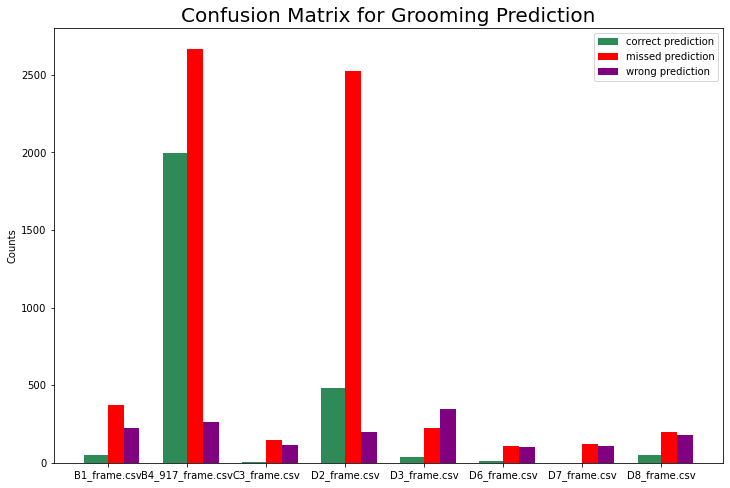

In [4]:
cm_data_test = plot_cm("comfusion_matirx_test_new.csv", 'ConfustionMatrix_test_new.png')

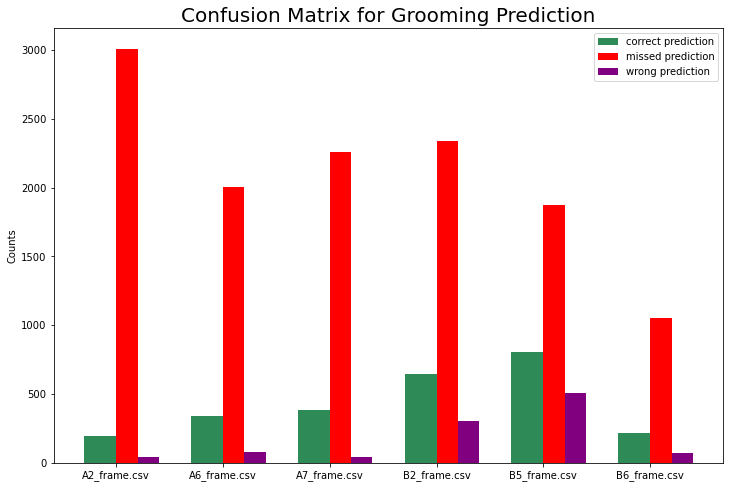

In [5]:
cm_data_train = plot_cm("comfusion_matirx_train.csv", 'ConfustionMatrix_train.png')

Precision: Percentage of grooming predictied correct among all grooming prediction.
Recall: Percentage of grooming predictied correct among all real grooming frames .


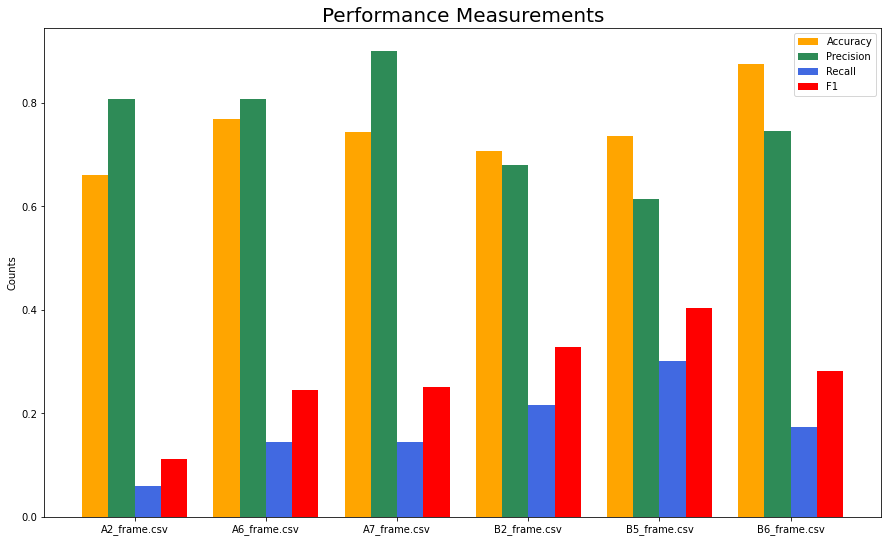

Mean accuracy of the model:  0.748
Mean precision of the model:  0.759
Mean recall of the model:  0.173


In [6]:
model_performence(cm_data_train, "Permormance_train.png")

Precision: Percentage of grooming predictied correct among all grooming prediction.
Recall: Percentage of grooming predictied correct among all real grooming frames .


/Users/jiangshan/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide


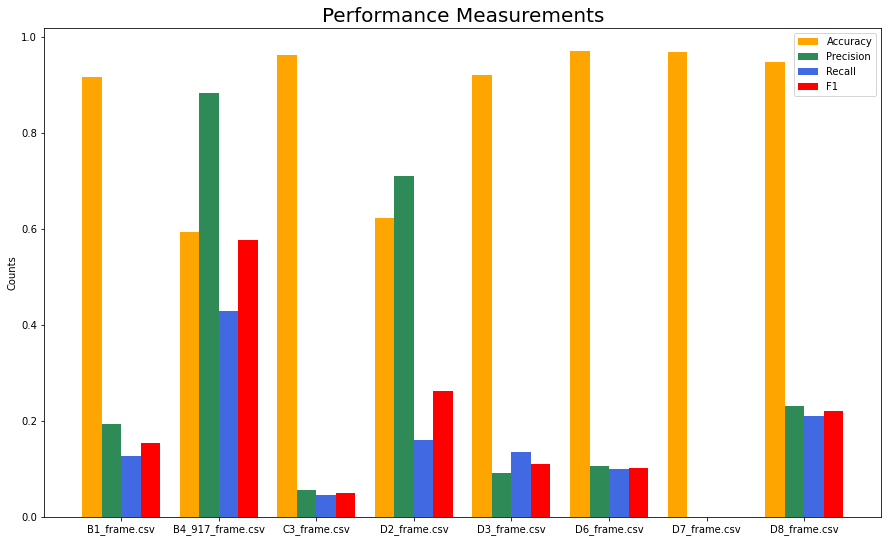

Mean accuracy of the model:  0.863
Mean precision of the model:  0.284
Mean recall of the model:  0.151


In [7]:
model_performence(cm_data_test, "Permormance_test.png")

# Compare real grooming time and predicted grooming time

In [8]:
train_path = "train/predicted/"
test_path = "test/predicted/"

train = sorted(os.listdir(train_path))
test = sorted(os.listdir(test_path))
# ignore all hidden files 
train = [f for f in train if not f.startswith('.')]
test = [f for f in test if not f.startswith('.')]
print(" Number of training mice:", len(train), '\n', 
      "Number of testing mice:", len(test))

 Number of training mice: 6 
 Number of testing mice: 8


In [9]:
# need total grooming time and non grooming time 
WT_grooming_time = []
WT_non_grooming_time = []
WT_names = []

for i in train:
    grooming, non_grooming = calculate_time(train_path+i)
    WT_grooming_time.append(grooming)
    WT_non_grooming_time.append(non_grooming)
    WT_names.append(i[:2])

KO_grooming_time = []
KO_non_grooming_time = []
KO_names = []

for i in test:
    grooming, non_grooming = calculate_time(test_path+i)
    KO_grooming_time.append(grooming)
    KO_non_grooming_time.append(non_grooming)
    KO_names.append(i[:2])    

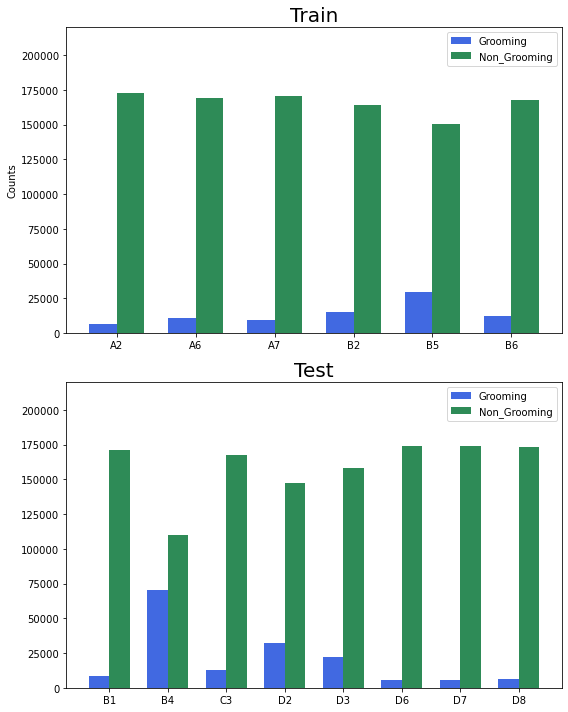

In [10]:
fig = plt.figure(figsize =(8,10))
width = 0.35       # the width of the bars

ax = plt.subplot(211)
ind = np.arange(len(WT_grooming_time))
rects1 = ax.bar(ind, WT_grooming_time, width, color='royalblue')
rects2 = ax.bar(ind+width, WT_non_grooming_time, width, color='seagreen')
ax.set_ylabel('Counts')
ax.set_title('Train', fontsize = 20)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(WT_names)
ax.legend( (rects1[0], rects2[0]), ('Grooming', 'Non_Grooming') )
ax.set_ylim(0,220000)


ax = plt.subplot(212)
ind = np.arange(len(KO_grooming_time))
rects1 = ax.bar(ind, KO_grooming_time, width, color='royalblue')
rects2 = ax.bar(ind+width, KO_non_grooming_time, width, color='seagreen')
ax.set_title('Test', fontsize = 20)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(KO_names)
ax.legend( (rects1[0], rects2[0]), ('Grooming', 'Non_Grooming') )
ax.set_ylim(0,220000)

plt.tight_layout()
fig.savefig("bar_train_test.png")

In [11]:
true_KO_names = ['A2', 'A6', 'A7', 'B2', 'B4', 'B5', 'B6', 'D2']
true_WT_names = ['B1', 'C3', 'D3', 'D6', 'D7', 'D8']

TRUE_WT_idx = []
TRUE_KO_idx = []
for i in KO_names:
    if i in true_WT_names:
        TRUE_WT_idx.append(KO_names.index(i))
    else:
        TRUE_KO_idx.append(KO_names.index(i))
        
KO_total = WT_grooming_time + [KO_grooming_time[i] for i in TRUE_KO_idx]
WT_total = [KO_grooming_time[i] for i in TRUE_WT_idx]
KO_non = WT_non_grooming_time + [KO_non_grooming_time[i] for i in TRUE_KO_idx]
WT_non = [KO_non_grooming_time[i] for i in TRUE_WT_idx]

KO_names_ordered = ['A2', 'A6', 'A7', 'B2', 'B5', 'B6','B4','D2']
WT_names_ordered = ['B1', 'C3', 'D3', 'D6', 'D7', 'D8']

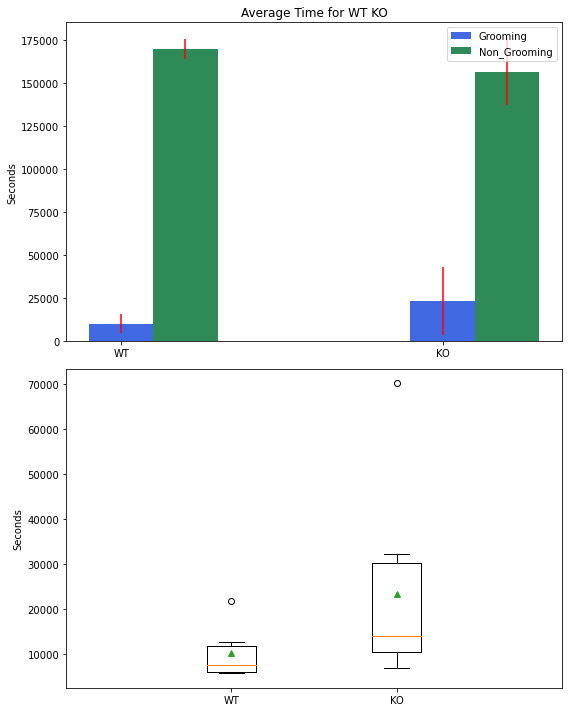

In [12]:
fig = plt.figure(figsize = (8,10))

mean_groom = [np.mean(WT_total), np.mean(KO_total)]
yerr_groom = [np.std(WT_total), np.std(KO_total)]
mean_non = [np.mean(WT_non), np.mean(KO_non)]
yerr_non = [np.std(WT_non), np.std(KO_non)]

plt.subplot(211)
b1 = plt.bar([0,1], mean_groom, 0.2,
       tick_label = ["WT", 'KO'],color='royalblue',
       yerr = yerr_groom, ecolor = 'red')
b2 = plt.bar([0.2, 1.2], mean_non, 0.2,
             color='seagreen',
       yerr = yerr_non, ecolor = 'red')

plt.ylabel("Seconds")
plt.legend( (b1[0], b2[0]), ('Grooming', 'Non_Grooming') )
plt.title("Average Time for WT KO")


plt.subplot(212)
plt.boxplot((WT_total,KO_total),
            positions=[1, 1.5],
            labels=["WT","KO"], showmeans = True)
plt.ylabel("Seconds")

plt.tight_layout()
fig.savefig("mean_and_boxplot_train_test.png")

In [13]:
ttest(WT_total, KO_total,equal_var=False)

Ttest_indResult(statistic=-1.6706226382509717, pvalue=0.13070905881056472)

In [14]:
temp = output_grooming_nongrooming([WT_total,WT_non],WT_names_ordered,'Total_time_summary_WT_21.csv')
_ = output_grooming_nongrooming([KO_total,KO_non],KO_names_ordered,'Total_time_summary_KO_21.csv')

file saved in  /Users/jiangshan/MIT/CRNN_model/Vis/frame_by_frame_model/21_length / Total_time_summary_WT_21.csv
file saved in  /Users/jiangshan/MIT/CRNN_model/Vis/frame_by_frame_model/21_length / Total_time_summary_KO_21.csv


Blue shows predicted; orange shows hand labeled.


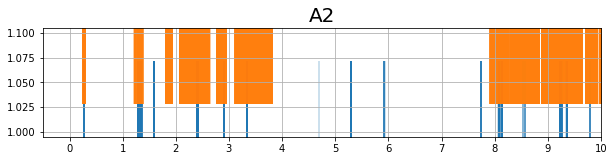

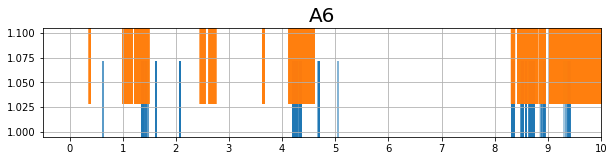

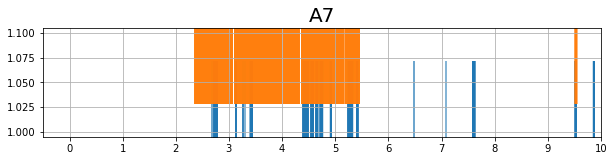

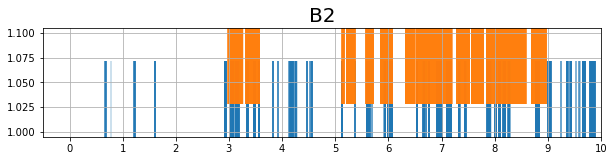

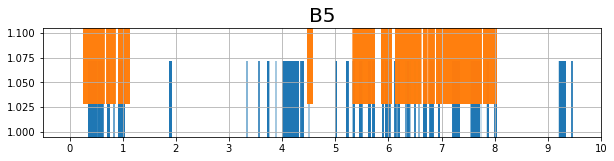

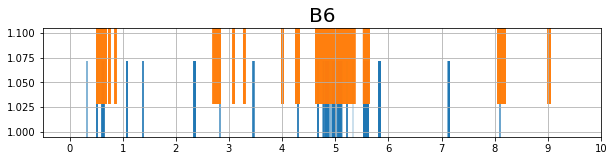

In [15]:
train_hand_path = "train/hand_label/"
train_hand_labels = sorted(os.listdir(train_hand_path))
train_hand_labels = [f for f in train_hand_labels if not f.startswith('.')]
#print(train_hand_labels)
for i in range(len(train)):
    hand_label = get_true_grooming(train_hand_path + train_hand_labels[i])
    pred_path = train_path + train[i]
    title = train[i][:2]
    fig, grooming = plot_grooming(hand_label, pred_path, title)
    fig_name = 'Compare_train_' + train[i][:2] +'.png'
    fig.savefig(fig_name)
print("Blue shows predicted; orange shows hand labeled.")

Blue shows predicted; orange shows hand labeled.


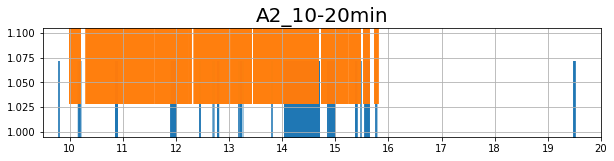

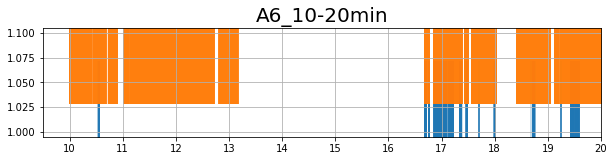

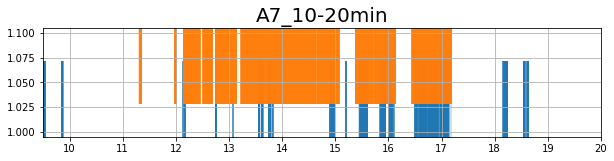

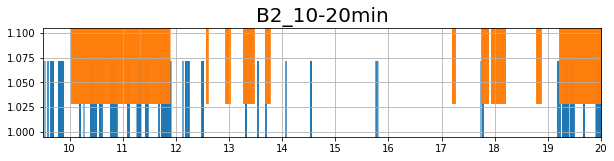

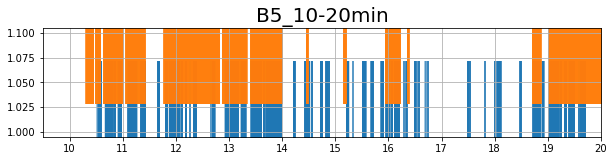

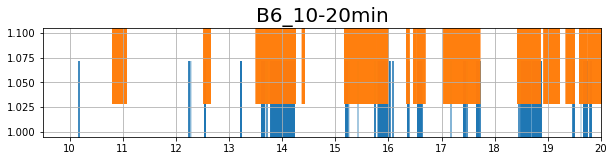

In [16]:
# comapre 10-20 min data
train_10_20_path = "../Train_10_20/"
train_10_20 = sorted(os.listdir(train_10_20_path))
train_10_20 = [f for f in train_10_20 if not f.startswith('.')]
#print(train_hand_labels)
precisions = []
recalls = []
for i in range(len(train)):
    hand_label = get_true_grooming(train_10_20_path + train_10_20[i])
    pred_path = train_path + train[i]
    title = train[i][:2] + '_10-20min'
    fig, grooming = plot_grooming(hand_label, pred_path, title,time = 2)
    fig_name = 'Compare_train_' + train[i][:2] +'_10_20.png'
    fig.savefig(fig_name)
    
    temp = grooming[grooming.index < 1800*20]
    temp = temp[temp.index > 1800*10]
    total_predicted = temp.index.values.shape[0]
    total_true_groom = len(hand_label)
    correct_groom_pred = len(list(set(temp.index.values) & set(hand_label)))
    wrong_groom_pred = total_predicted - correct_groom_pred
    precision = correct_groom_pred/total_predicted
    recall = correct_groom_pred/total_true_groom
    precisions.append(precision)
    recalls.append(recall)
print("Blue shows predicted; orange shows hand labeled.")

(0.0, 1.2)

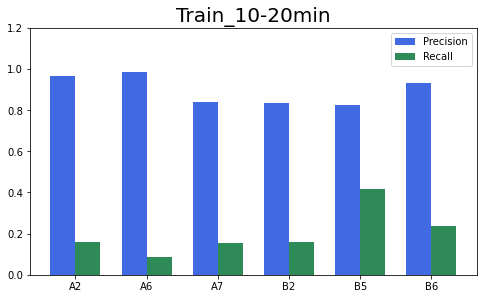

In [17]:
fig = plt.figure(figsize =(8,10))
width = 0.35       # the width of the bars

ax = plt.subplot(211)
ind = np.arange(len(precisions))
rects1 = ax.bar(ind, precisions, width, color='royalblue')
rects2 = ax.bar(ind+width, recalls, width, color='seagreen')
#ax.set_ylabel('Counts')
ax.set_title('Train_10-20min', fontsize = 20)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(WT_names)
ax.legend( (rects1[0], rects2[0]), ('Precision', 'Recall') )
ax.set_ylim(0,1.2)


In [18]:
len(hand_label)

7080

Blue shows predicted; orange shows hand labeled.


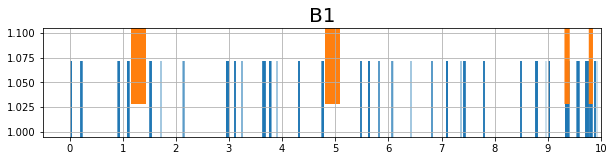

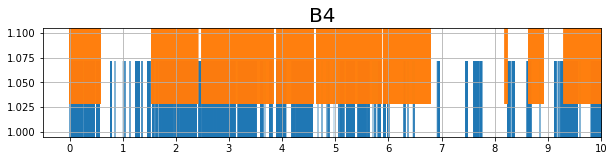

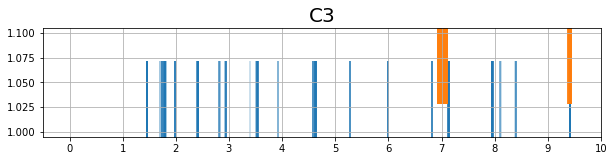

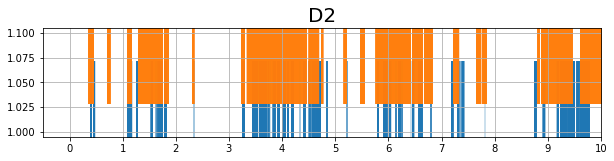

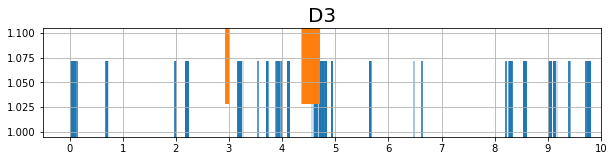

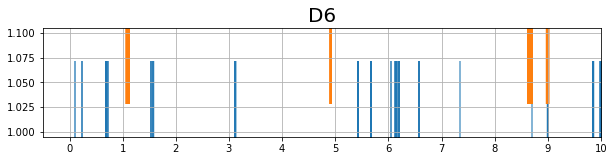

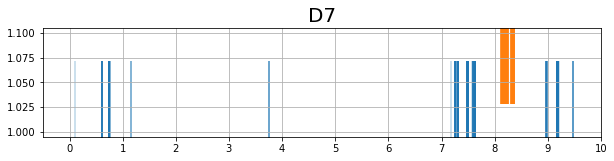

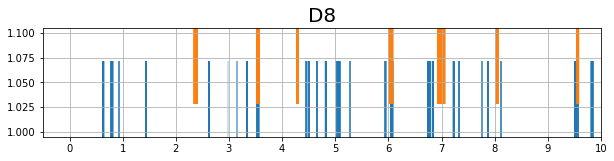

In [19]:
test_hand_path = "test/hand_label/"
test_hand_labels = sorted(os.listdir(test_hand_path))
test_hand_labels = [f for f in test_hand_labels if not f.startswith('.')]
#print(train_hand_labels)
for i in range(len(test)):
    hand_label = get_true_grooming(test_hand_path + test_hand_labels[i])
    pred_path = test_path + test[i]
    title = test[i][:2]
    fig,grooming = plot_grooming(hand_label, pred_path, title)
    fig_name = 'Compare_test_' + test[i][:2] +'.png'
    fig.savefig(fig_name)
print("Blue shows predicted; orange shows hand labeled.")

## Apply filter on grooming prediction

Blue shows predicted; orange shows hand labeled.


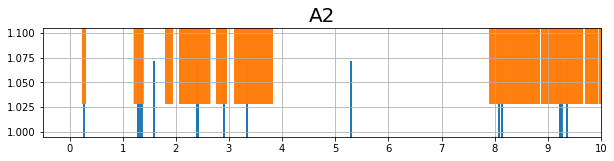

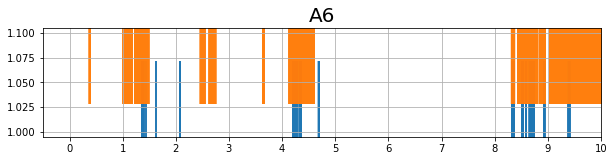

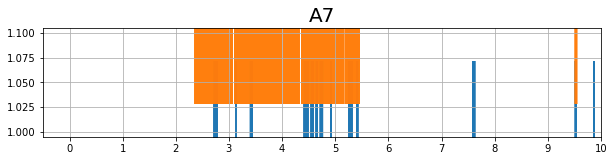

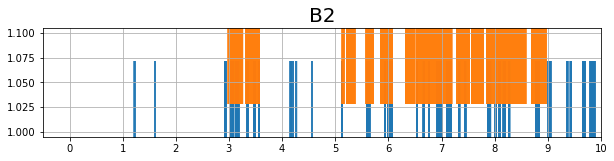

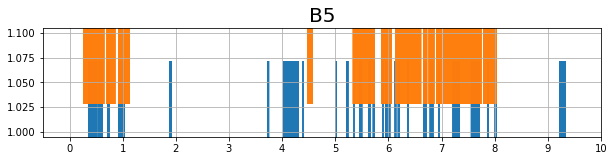

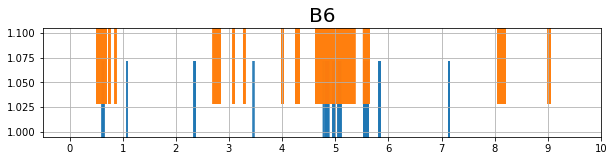

In [20]:
train_hand_path = "train/hand_label/"
train_hand_labels = sorted(os.listdir(train_hand_path))
train_hand_labels = [f for f in train_hand_labels if not f.startswith('.')]
#print(train_hand_labels)
for i in range(len(train)):
    hand_label = get_true_grooming(train_hand_path + train_hand_labels[i])
    pred_path = train_path + train[i]
    title = train[i][:2]
    fig, grooming = plot_grooming(hand_label, pred_path, title, filter_out = True)
    fig_name = 'Compare_train_' + train[i][:2] +'_filtered.png'
    fig.savefig(fig_name)
print("Blue shows predicted; orange shows hand labeled.")

Blue shows predicted; orange shows hand labeled.


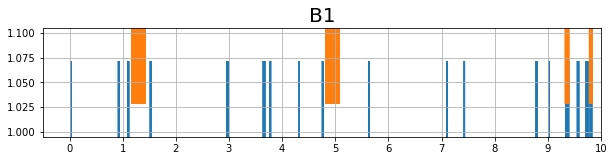

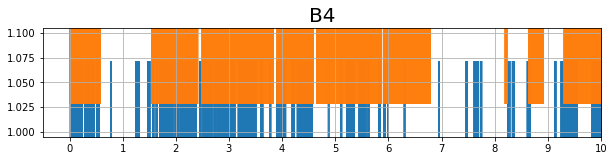

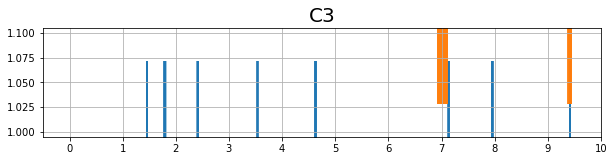

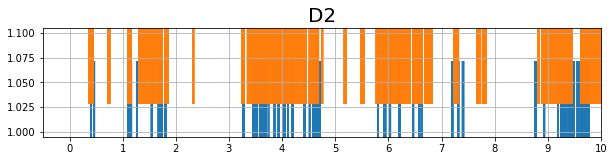

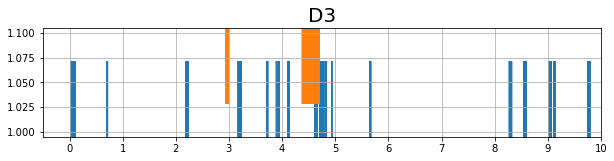

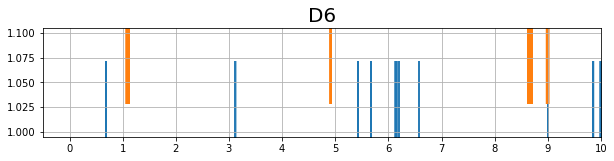

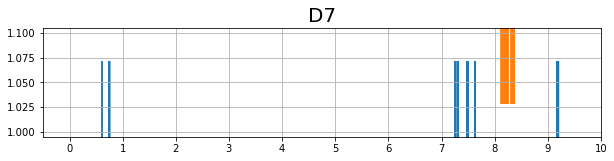

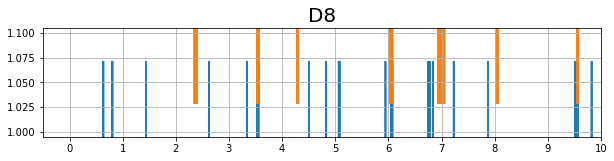

In [21]:
test_hand_path = "test/hand_label/"
test_hand_labels = sorted(os.listdir(test_hand_path))
test_hand_labels = [f for f in test_hand_labels if not f.startswith('.')]
#print(train_hand_labels)
for i in range(len(test)):
    hand_label = get_true_grooming(test_hand_path + test_hand_labels[i])
    pred_path = test_path + test[i]
    title = test[i][:2]
    fig,grooming = plot_grooming(hand_label, pred_path, title, True)
    fig_name = 'Compare_test_' + test[i][:2] +'_filtered.png'
    fig.savefig(fig_name)
print("Blue shows predicted; orange shows hand labeled.")

# Train on sequence length = 31

In [22]:
os.chdir("../31_length/")

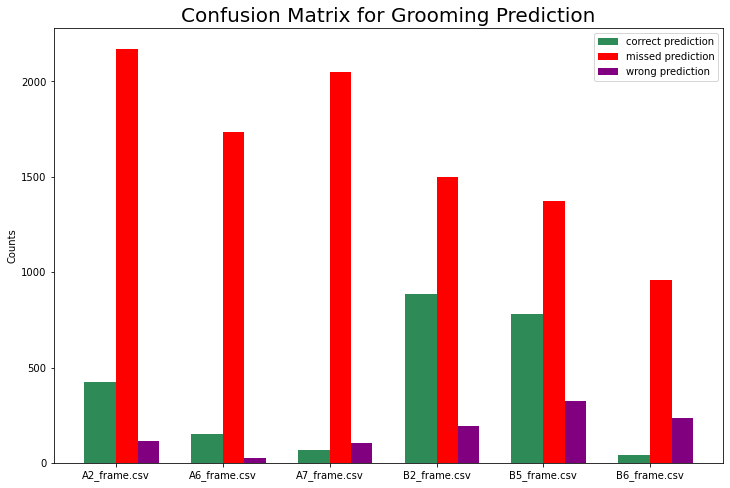

In [23]:
cm_data_train_31 = plot_cm("comfusion_matirx_train_31_length.csv", 'ConfustionMatrix_train_31_length.png')

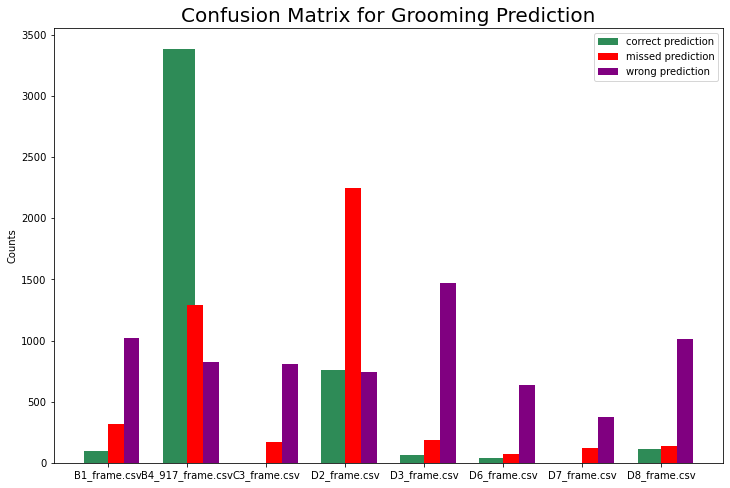

In [24]:
cm_data_test_31 = plot_cm("comfusion_matirx_test_31length.csv", 'ConfustionMatrix_test_31_length.png')

Precision: Percentage of grooming predictied correct among all grooming prediction.
Recall: Percentage of grooming predictied correct among all real grooming frames .


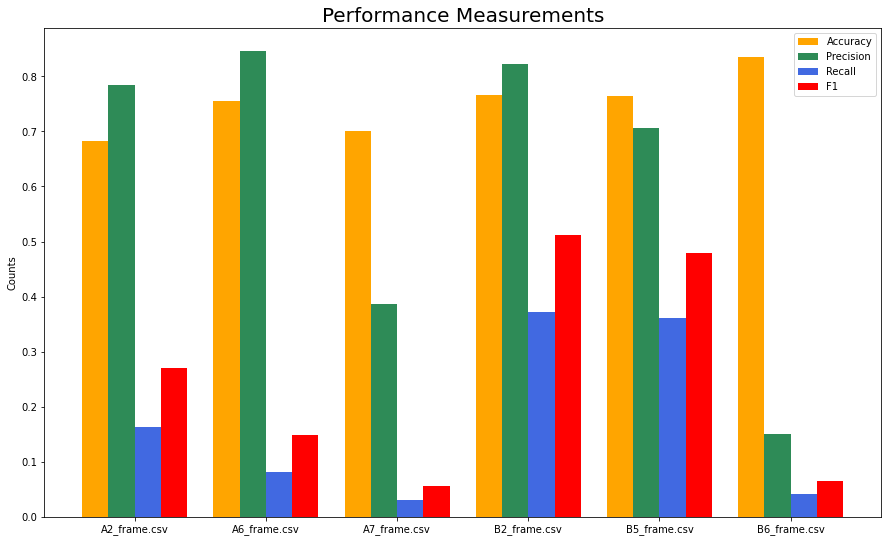

Mean accuracy of the model:  0.75
Mean precision of the model:  0.616
Mean recall of the model:  0.175


In [25]:
model_performence(cm_data_train_31, "Permormance_train_31_length.png")

Precision: Percentage of grooming predictied correct among all grooming prediction.
Recall: Percentage of grooming predictied correct among all real grooming frames .


/Users/jiangshan/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide


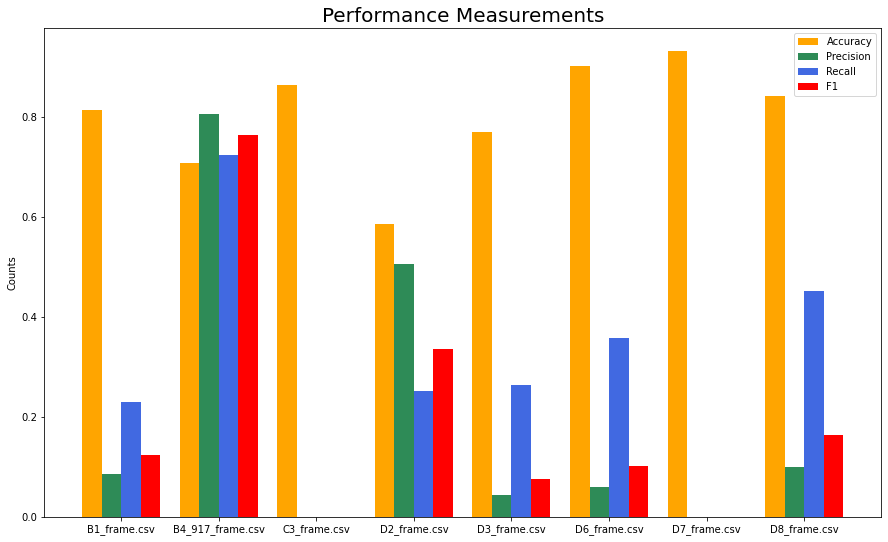

Mean accuracy of the model:  0.802
Mean precision of the model:  0.2
Mean recall of the model:  0.285


In [26]:
model_performence(cm_data_test_31, "Permormance_test_31_length.png")

In [27]:
train_path = "31_length_train/"
test_path = "31_length_test/"

train = sorted(os.listdir(train_path))
test = sorted(os.listdir(test_path))
# ignore all hidden files 
train = [f for f in train if not f.startswith('.')]
test = [f for f in test if not f.startswith('.')]
print(" Number of KO mice:", len(train), '\n', 
      "Number of WT mice:", len(test))

 Number of KO mice: 6 
 Number of WT mice: 8


In [28]:
# need total grooming time and non grooming time 
WT_grooming_time = []
WT_non_grooming_time = []
WT_names = []

for i in train:
    grooming, non_grooming = calculate_time(train_path+i)
    WT_grooming_time.append(grooming)
    WT_non_grooming_time.append(non_grooming)
    WT_names.append(i[:2])

KO_grooming_time = []
KO_non_grooming_time = []
KO_names = []

for i in test:
    grooming, non_grooming = calculate_time(test_path+i)
    KO_grooming_time.append(grooming)
    KO_non_grooming_time.append(non_grooming)
    KO_names.append(i[:2])    
    

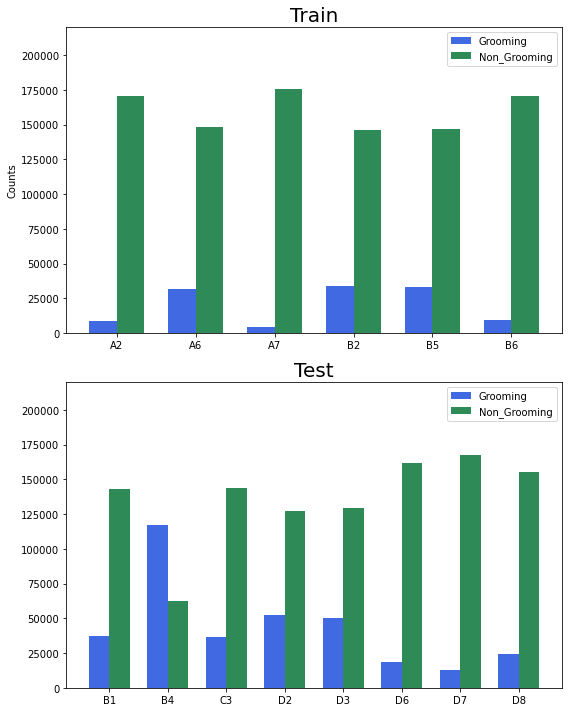

In [29]:
fig = plt.figure(figsize =(8,10))
width = 0.35       # the width of the bars

ax = plt.subplot(211)
ind = np.arange(len(WT_grooming_time))
rects1 = ax.bar(ind, WT_grooming_time, width, color='royalblue')
rects2 = ax.bar(ind+width, WT_non_grooming_time, width, color='seagreen')
ax.set_ylabel('Counts')
ax.set_title('Train', fontsize = 20)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(WT_names)
ax.legend( (rects1[0], rects2[0]), ('Grooming', 'Non_Grooming') )
ax.set_ylim(0,220000)


ax = plt.subplot(212)
ind = np.arange(len(KO_grooming_time))
rects1 = ax.bar(ind, KO_grooming_time, width, color='royalblue')
rects2 = ax.bar(ind+width, KO_non_grooming_time, width, color='seagreen')
ax.set_title('Test', fontsize = 20)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(KO_names)
ax.legend( (rects1[0], rects2[0]), ('Grooming', 'Non_Grooming') )
ax.set_ylim(0,220000)

plt.tight_layout()
fig.savefig("bar_train_test_31length.png")

In [30]:
true_KO_names = ['A2', 'A6', 'A7', 'B2', 'B4', 'B5', 'B6', 'D2']
true_WT_names = ['B1', 'C3', 'D3', 'D6', 'D7', 'D8']

TRUE_WT_idx = []
TRUE_KO_idx = []
for i in KO_names:
    if i in true_WT_names:
        TRUE_WT_idx.append(KO_names.index(i))
    else:
        TRUE_KO_idx.append(KO_names.index(i))
        
KO_total = WT_grooming_time + [KO_grooming_time[i] for i in TRUE_KO_idx]
WT_total = [KO_grooming_time[i] for i in TRUE_WT_idx]
KO_non = WT_non_grooming_time + [KO_non_grooming_time[i] for i in TRUE_KO_idx]
WT_non = [KO_non_grooming_time[i] for i in TRUE_WT_idx]

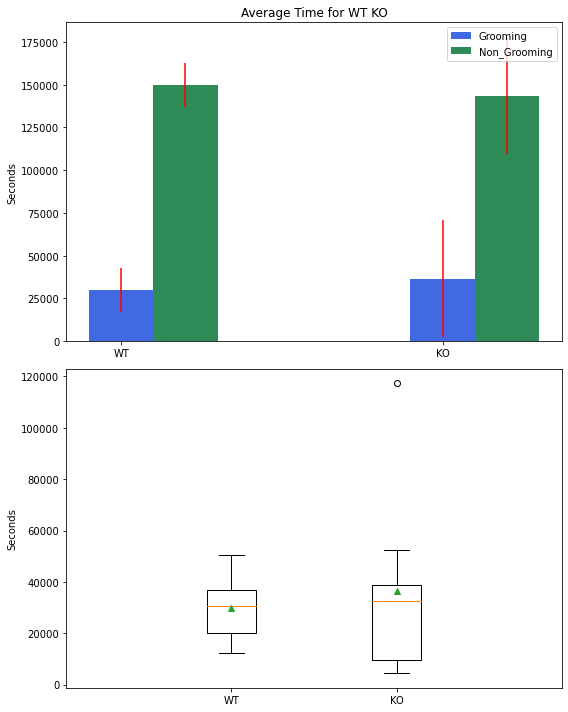

In [31]:
fig = plt.figure(figsize = (8,10))


mean_groom = [np.mean(WT_total), np.mean(KO_total)]
yerr_groom = [np.std(WT_total), np.std(KO_total)]
mean_non = [np.mean(WT_non), np.mean(KO_non)]
yerr_non = [np.std(WT_non), np.std(KO_non)]

plt.subplot(211)
b1 = plt.bar([0,1], mean_groom, 0.2,
       tick_label = ["WT", 'KO'],color='royalblue',
       yerr = yerr_groom, ecolor = 'red')
b2 = plt.bar([0.2, 1.2], mean_non, 0.2,
             color='seagreen',
       yerr = yerr_non, ecolor = 'red')

plt.ylabel("Seconds")
plt.legend( (b1[0], b2[0]), ('Grooming', 'Non_Grooming') )
plt.title("Average Time for WT KO")


plt.subplot(212)
plt.boxplot((WT_total,KO_total),
            positions=[1, 1.5],
            labels=["WT","KO"], showmeans = True)
plt.ylabel("Seconds")

plt.tight_layout()
fig.savefig("mean_and_boxplot_train_test_31length.png")

In [32]:
ttest(WT_total, KO_total,equal_var=False)

Ttest_indResult(statistic=-0.4649421798739535, pvalue=0.6524388874306709)

In [33]:
temp = output_grooming_nongrooming([WT_total,WT_non],WT_names_ordered,'Total_time_summary_WT_31.csv')
_ = output_grooming_nongrooming([KO_total,KO_non],KO_names_ordered,'Total_time_summary_KO_31.csv')

file saved in  /Users/jiangshan/MIT/CRNN_model/Vis/frame_by_frame_model/31_length / Total_time_summary_WT_31.csv
file saved in  /Users/jiangshan/MIT/CRNN_model/Vis/frame_by_frame_model/31_length / Total_time_summary_KO_31.csv


Blue shows predicted; orange shows hand labeled.


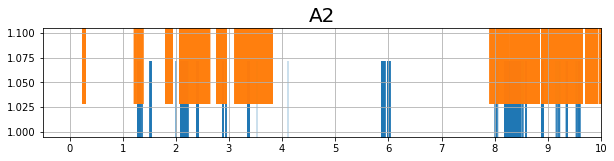

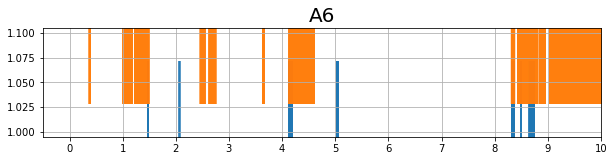

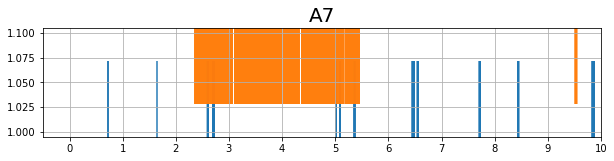

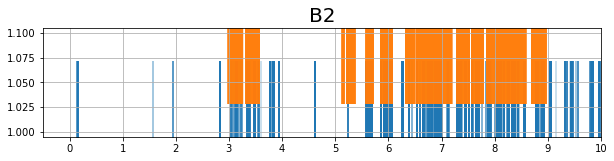

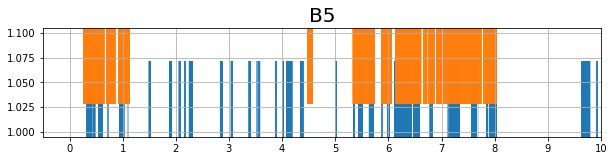

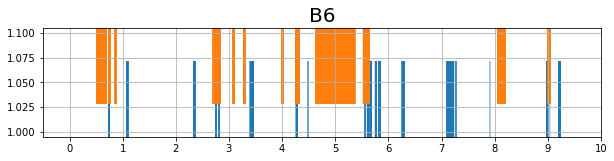

In [34]:
train_hand_path = "../21_length/train/hand_label/"
train_hand_labels = sorted(os.listdir(train_hand_path))
train_hand_labels = [f for f in train_hand_labels if not f.startswith('.')]
#print(train_hand_labels)
for i in range(len(train)):
    hand_label = get_true_grooming(train_hand_path + train_hand_labels[i])
    pred_path = train_path + train[i]
    title = train[i][:2]
    fig,_ = plot_grooming(hand_label, pred_path, title)
    fig_name = 'Compare_train_' + train[i][:2] +'_31_length.png'
    fig.savefig(fig_name)
print("Blue shows predicted; orange shows hand labeled.")

Blue shows predicted; orange shows hand labeled.


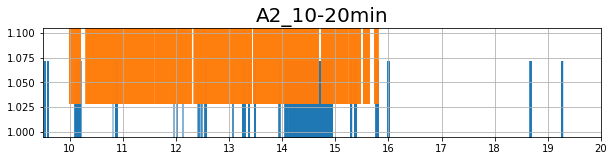

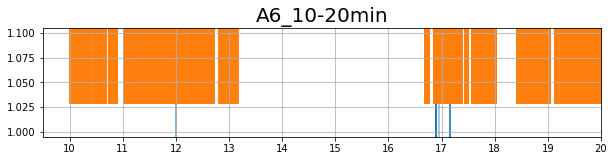

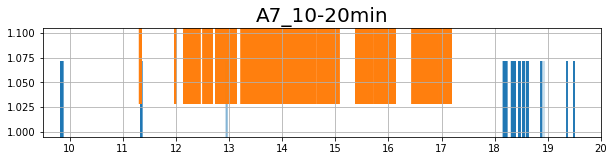

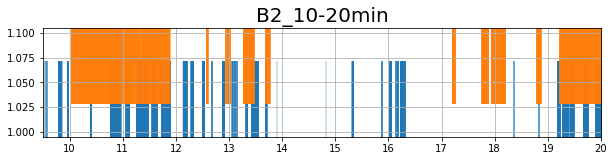

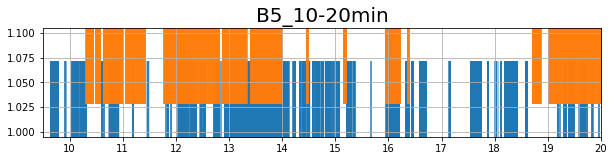

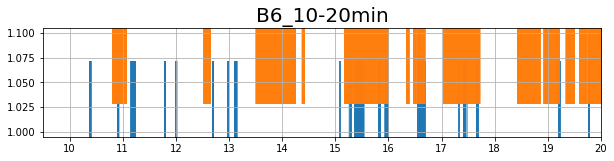

In [35]:
train_10_20_path = "../Train_10_20/"
train_10_20 = sorted(os.listdir(train_10_20_path))
train_10_20 = [f for f in train_10_20 if not f.startswith('.')]
#print(train_hand_labels)
precisions = []
recalls = []
for i in range(len(train)):
    hand_label = get_true_grooming(train_10_20_path + train_10_20[i])
    pred_path = train_path + train[i]
    title = train[i][:2] + '_10-20min'
    fig, grooming = plot_grooming(hand_label, pred_path, title,time = 2)
    fig_name = 'Compare_train_' + train[i][:2] +'_10_20.png'
    fig.savefig(fig_name)
    
    temp = grooming[grooming.index < 1800*20]
    temp = temp[temp.index > 1800*10]
    total_predicted = temp.index.values.shape[0]
    total_true_groom = len(hand_label)
    correct_groom_pred = len(list(set(temp.index.values) & set(hand_label)))
    wrong_groom_pred = total_predicted - correct_groom_pred
    precision = correct_groom_pred/total_predicted
    recall = correct_groom_pred/total_true_groom
    precisions.append(precision)
    recalls.append(recall)
print("Blue shows predicted; orange shows hand labeled.")

(0.0, 1.2)

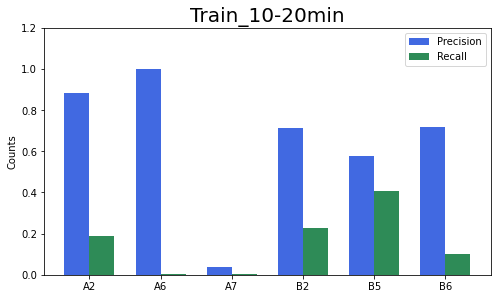

In [36]:
fig = plt.figure(figsize =(8,10))
width = 0.35       # the width of the bars

ax = plt.subplot(211)
ind = np.arange(len(precisions))
rects1 = ax.bar(ind, precisions, width, color='royalblue')
rects2 = ax.bar(ind+width, recalls, width, color='seagreen')
ax.set_ylabel('Counts')
ax.set_title('Train_10-20min', fontsize = 20)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(WT_names)
ax.legend( (rects1[0], rects2[0]), ('Precision', 'Recall') )
ax.set_ylim(0,1.2)


Blue shows predicted; orange shows hand labeled.


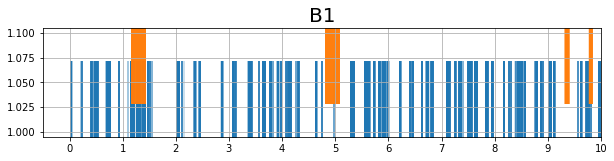

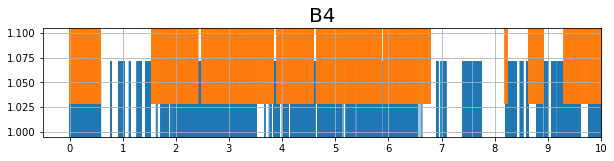

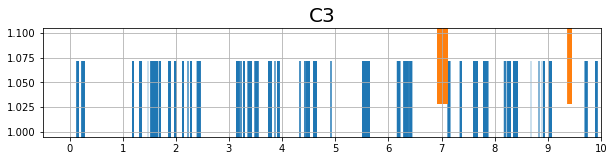

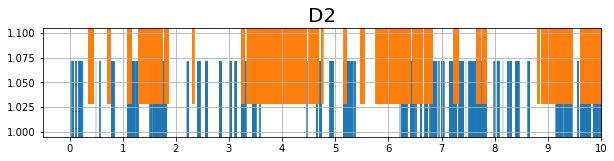

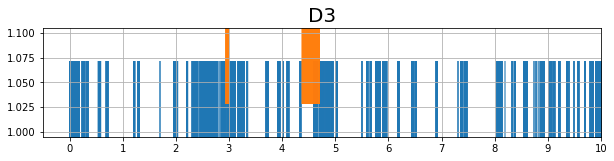

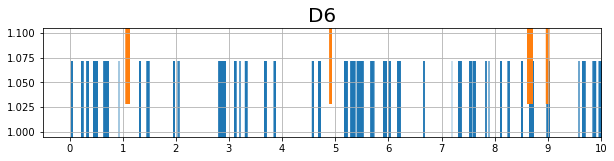

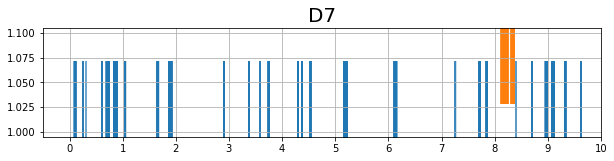

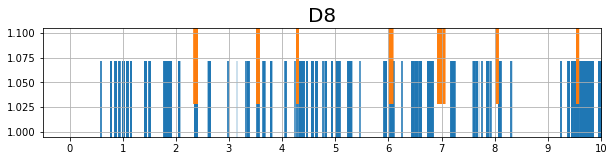

In [37]:
test_hand_path = "../21_length/test/hand_label/"
test_hand_labels = sorted(os.listdir(test_hand_path))
test_hand_labels = [f for f in test_hand_labels if not f.startswith('.')]
#print(train_hand_labels)
for i in range(len(test)):
    hand_label = get_true_grooming(test_hand_path + test_hand_labels[i])
    pred_path = test_path + test[i]
    title = test[i][:2]
    fig,_ = plot_grooming(hand_label, pred_path, title)
    fig_name = 'Compare_test_' + test[i][:2] +'_31_length.png'
    fig.savefig(fig_name)
print("Blue shows predicted; orange shows hand labeled.")

# Train on raw videos

In [38]:
os.chdir("../raw_video_model/")

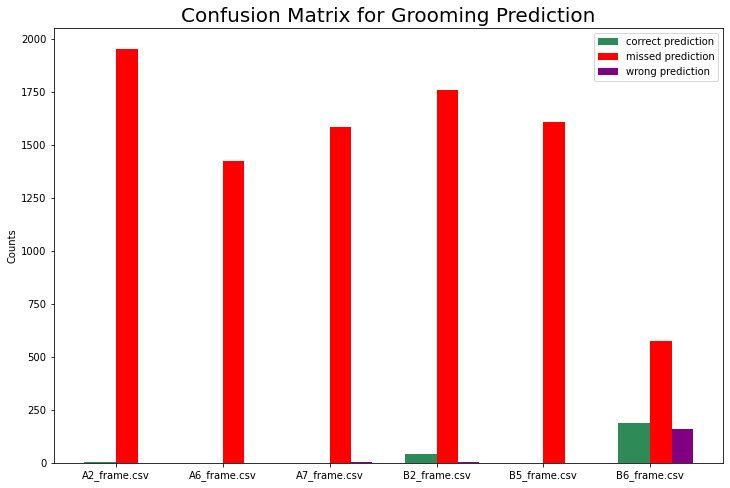

In [39]:
cm_data_train_raw = plot_cm("comfusion_matirx_raw_train.csv", 'ConfustionMatrix_train_raw.png')
# this model can not detect grooming well.
# it can detect some grooming in the last video in training
# that may because there have some big difference between videos
# the model has been shift to fit B6 at the end
# and gradually erase fitting for pervious mice
# A6 has the worst performence 

Precision: Percentage of grooming predictied correct among all grooming prediction.
Recall: Percentage of grooming predictied correct among all real grooming frames .


/Users/jiangshan/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in true_divide
/Users/jiangshan/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide


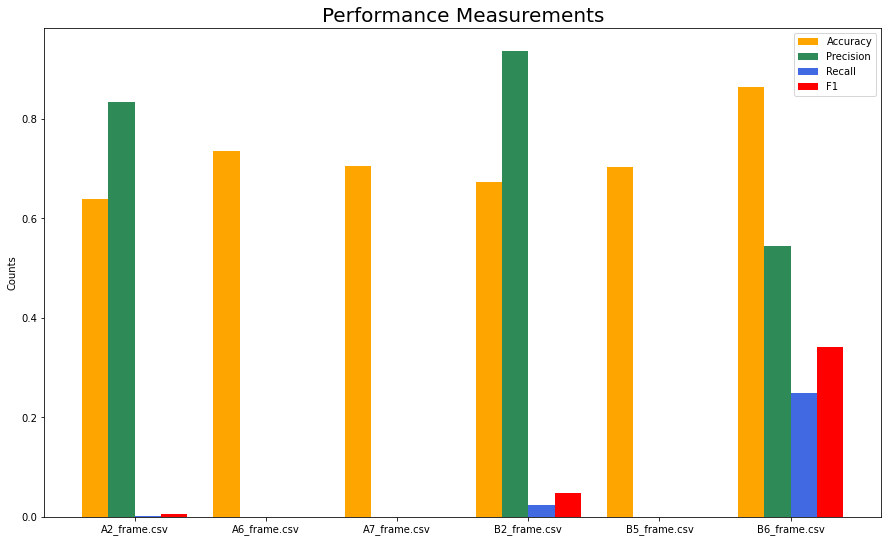

Mean accuracy of the model:  0.72
Mean precision of the model:  nan
Mean recall of the model:  0.046


/Users/jiangshan/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in true_divide


In [40]:
model_performence(cm_data_train_raw, "Permormance_train_raw.png")

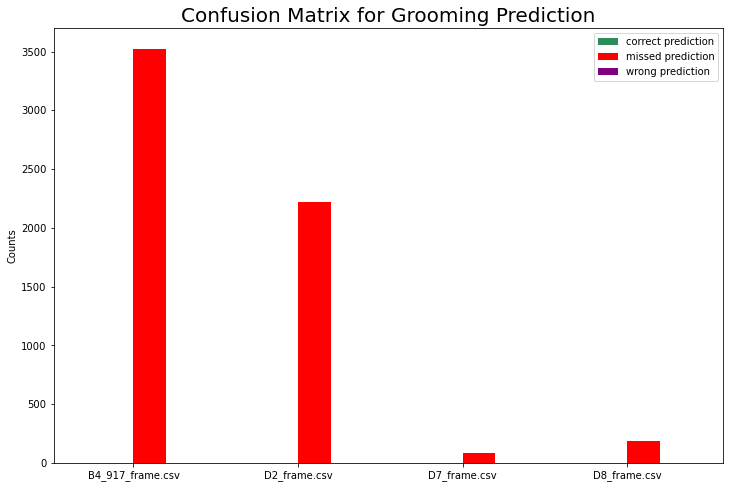

In [41]:
cm_data_test_raw = plot_cm("comfusion_matirx_raw_test.csv", 'ConfustionMatrix_test_raw.png')

Precision: Percentage of grooming predictied correct among all grooming prediction.
Recall: Percentage of grooming predictied correct among all real grooming frames .


/Users/jiangshan/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in true_divide


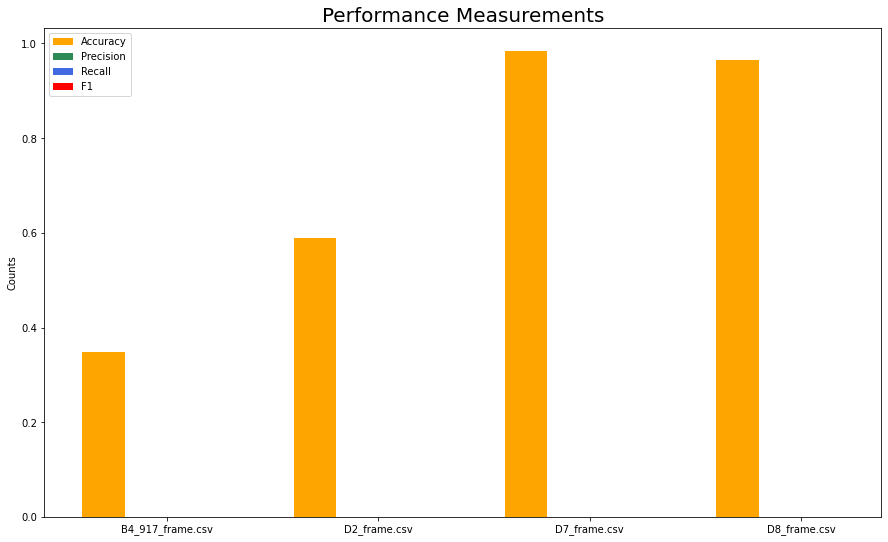

Mean accuracy of the model:  0.722
Mean precision of the model:  nan
Mean recall of the model:  0.0


/Users/jiangshan/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in true_divide


In [42]:
model_performence(cm_data_test_raw, "Permormance_test_raw.png")